In [1]:
from settings import Settings
import matplotlib.pyplot as plt

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from utils.datasets import TrainDataset, TestDataset
from torchvision.transforms import *
from torch.autograd import Variable
from model import Net
from model import SRCNN
from tensorboardX import SummaryWriter
from PIL import Image
from utils.psnr import PSNR
import numpy as np
import math

In [2]:
settings = Settings()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(settings.dataset_info['291'])
print(settings.lr)

cuda
{'random_scale_factor': False, 'random_scale': False, 'rotate': True, 'scale_factor': 2, 'fliplr': True, 'is_gray': False, 'crop_size': 36, 'fliptb': True, 'link': '1Rt3asDLuMgLuJvPA1YrhyjWhb97Ly742', 'path': './'}
0.0001


In [3]:
def load_dataset(dataset='train'):
    if settings.num_channels == 1:
        is_gray = True
    else:
        is_gray = False

    if dataset == 'train':
        print('Loading train datasets...')
        train_set = TrainDataset(settings=settings)
        return DataLoader(dataset=train_set, num_workers=settings.num_threads, batch_size=settings.batch_size,
                          shuffle=True, drop_last=True)
    elif dataset == 'test':
        print('Loading test datasets...')
        test_set = TestDataset(settings=settings)
        return DataLoader(dataset=test_set, num_workers=settings.num_threads, batch_size=settings.test_batch_size,
                          shuffle=False)
    elif dataset == 'gdata':
        print('github')
        train_set = DatasetFromHdf5('datasets/data/train.h5')
        return DataLoader(dataset=train_set, num_workers=settings.num_threads, batch_size=settings.test_batch_size,
                          shuffle=True)
        

In [4]:
def save_checkpoint(model, epoch):
    model_out_path = "checkpoint/" + "model_epoch_{}.pth".format(epoch)
    state = {"epoch": epoch ,"model": model}
    if not os.path.exists("checkpoint/"):
        os.makedirs("checkpoint/")

    torch.save(state, model_out_path)

    print("Checkpoint saved to {}".format(model_out_path))

In [5]:
def train(training_data_loader, testing_data_loader, optimizer, model, criterion, epoch, writer, log_iter, test_log_iter):
    #lr = adjust_learning_rate(optimizer, epoch)
    #lr = 1e-4
    for param_group in optimizer.param_groups:
        lr = param_group["lr"]
        
    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))
    avg_loss = 0.0
    for _ in range(15):
        for iteration, batch in enumerate(training_data_loader):
            input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)
            input = input.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            loss = criterion(model(input), target)
            loss.backward() 

            #nn.utils.clip_grad_norm_(model.parameters(), settings.clip) 
            optimizer.step()

            writer.add_scalar('loss/L2_loss', loss.item()/settings.batch_size, log_iter)
            writer.add_scalar('loss/PSNR', 10*math.log10(1/loss.item()),log_iter)
            
            avg_loss += loss.item()
            log_iter += 1
        
        with torch.no_grad():
            psnrs = []
            bic_psnrs = []
            cnt = 0
            for iteration, batch in enumerate(testing_data_loader):
                bicubic, hires = Variable(batch[0], requires_grad=False), batch[1]
                bicubic = bicubic.to(device)
                out = model(bicubic).cpu().detach().numpy().squeeze(0)
                
                bicubic = bicubic.cpu().detach().numpy().squeeze(0)
                hires = hires.squeeze(0)
                
                bicubic *= 255
                hires *= 255
                out *= 255
                
                bicubic = np.uint8(bicubic).transpose(2,1,0)
                hires = np.uint8(hires).transpose(2,1,0)
                out = np.uint8(out).transpose(2,1,0)

                ps = PSNR(hires, out, ycbcr=True)
                bps = PSNR(hires, bicubic, ycbcr=True)

                psnrs.append(ps)
                bic_psnrs.append(bps)
                
            avg_psnr = np.mean(psnrs)
            avg_bic_psnr = np.mean(bic_psnrs)
            writer.add_scalar('loss/PSNR_test', avg_psnr,test_log_iter)
            writer.add_scalar('loss/PSNR_test_improve', avg_psnr-avg_bic_psnr, test_log_iter)
            test_log_iter += 1
        
        
    return log_iter, test_log_iter

In [6]:
train_data = load_dataset('train')
test_data = load_dataset('test')
print(train_data)
print(test_data)

Loading train datasets...
Successfully loaded.
/home/sunghwan19/VDSR-pytorch/datasets/291
Loading test datasets...
Successfully loaded.


Text(0.5, 1.0, 'High Resolution')

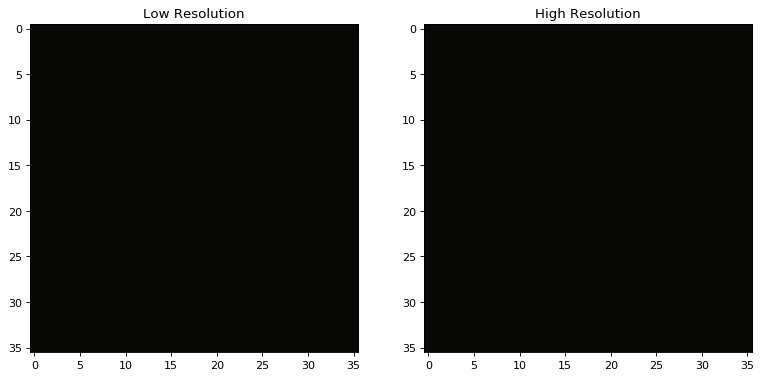

In [7]:
lr = None
hr = None

for idx, batch in enumerate(train_data):
    lr = batch[0][0].numpy().transpose(2,1,0)
    hr = batch[1][0].numpy().transpose(2,1,0)

fig = plt.figure(figsize=(18, 16), dpi= 80)
ax = plt.subplot("131")
ax.imshow(lr)
ax.set_title("Low Resolution")

ax = plt.subplot("132")
ax.imshow(hr)
ax.set_title("High Resolution")

In [8]:
#model = Net().to(device)
model = torch.load('checkpoint/model_epoch_30.pth')['model'].to(device)
writer = SummaryWriter()

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
criterion = nn.MSELoss()

total_epoch = 80
total_iter = 0
test_iter = 0

for epoch in range(total_epoch):
    total_iter, test_iter = train(train_data, test_data, optimizer, model, criterion, epoch, writer=writer, log_iter=total_iter, test_log_iter=test_iter)
    #scheduler.step()
    save_checkpoint(model, epoch)

Epoch = 0, lr = 0.001
Checkpoint saved to checkpoint/model_epoch_0.pth
Epoch = 1, lr = 0.001


/home/sunghwan19/.local/lib/python3.5/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/sunghwan19/.local/lib/python3.5/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/sunghwan19/.local/lib/python3.5/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/sunghwan19/.local/lib/python3.5/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv_Block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + 

Checkpoint saved to checkpoint/model_epoch_1.pth
Epoch = 2, lr = 0.001
Checkpoint saved to checkpoint/model_epoch_2.pth
Epoch = 3, lr = 0.001
Checkpoint saved to checkpoint/model_epoch_3.pth
Epoch = 4, lr = 0.001
Checkpoint saved to checkpoint/model_epoch_4.pth
Epoch = 5, lr = 0.001
Checkpoint saved to checkpoint/model_epoch_5.pth
Epoch = 6, lr = 0.001
Checkpoint saved to checkpoint/model_epoch_6.pth
Epoch = 7, lr = 0.001
Checkpoint saved to checkpoint/model_epoch_7.pth
Epoch = 8, lr = 0.001
Checkpoint saved to checkpoint/model_epoch_8.pth
Epoch = 9, lr = 0.001
Checkpoint saved to checkpoint/model_epoch_9.pth
Epoch = 10, lr = 0.001
Checkpoint saved to checkpoint/model_epoch_10.pth
Epoch = 11, lr = 0.001


KeyboardInterrupt: 

In [8]:
#model = torch.load('checkpoint/model_epoch_79.pth')['model'].to(device)
#model = Net().to(device)
model = torch.load('checkpoint/model_epoch_67.pth')['model'].to(device)
#test_dataset = load_dataset('train')
test = test_data.dataset.__getitem__(3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


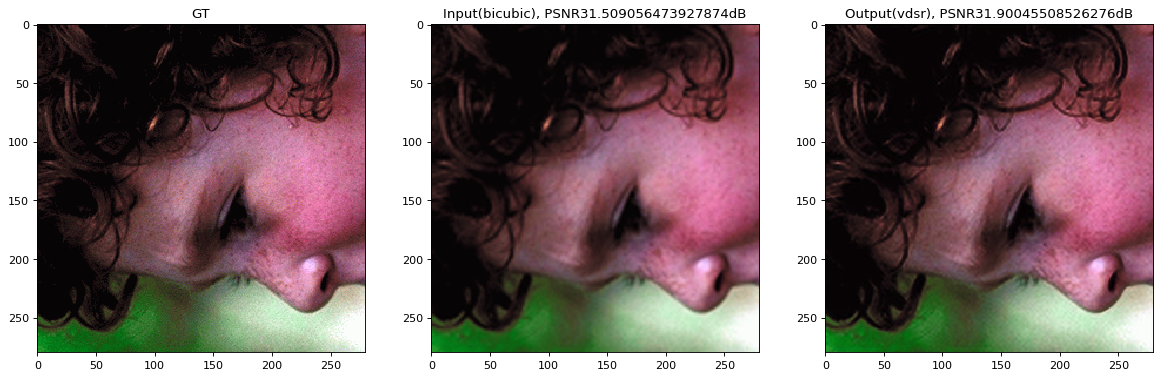

In [16]:
bef = test[1].numpy() *255
aft = model(torch.Tensor(test[0].numpy()).unsqueeze(0).to(device)).cpu().detach().numpy().squeeze(0)*255
bic = test[0].numpy() * 255
psnr = PSNR(bef, aft)
psnr_bic = PSNR(bef, bic)
# Result visualization
fig = plt.figure(figsize=(18, 16), dpi= 80)
ax = plt.subplot("131")
ax.imshow(test[1].numpy().transpose((2, 1, 0)))
ax.set_title("GT")

ax = plt.subplot("132")
ax.imshow(test[0].numpy().transpose((2, 1, 0)))
ax.set_title("Input(bicubic), PSNR"+str(psnr_bic)+"dB")

ax = plt.subplot("133")
ax.imshow(model(torch.Tensor(test[0].numpy()).unsqueeze(0).to(device)).cpu().detach().numpy().squeeze(0).transpose(2,1,0))
ax.set_title("Output(vdsr), PSNR"+str(psnr)+"dB")
plt.show()

In [17]:
dbs = []
for _, batch in enumerate(test_data):
    bicubic, hires = np.array(batch[0]).squeeze(0), np.array(batch[1]).squeeze(0)
    bicubic *= 255
    hires *= 255
    bicubic = np.uint8(bicubic).transpose(2,1,0)
    hires = np.uint8(hires).transpose(2,1,0)

    db = PSNR(hires, bicubic, ycbcr=True)
    dbs.append(db)

print(np.mean(dbs))

33.672577179247014
